In [22]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress = True)

In [139]:
#Init parameters
S0_init = 30       #S_0
K_init = 30        #Strike price (=S_0)
T_init = 10        #Maturity
v_init = 3         #Vesting period
r_init = 0.045      #RF rate
N_init = 10        #Height of tree
sigma_init = 0.3   #Volatility
m_init = 2         #Exercise multiple (m>1)

#For R option: alpha is percentage that gets converted to stock, gamma the "risk premium"
alpha_init = 0.9
gamma_init = 0.05

In [140]:
alpha_init = 0.75
gamma_init = 0.1
rho_init = 2


# Agent's parameters - 67/33
c_init = 1700000  # Agent's initial wealth
n_s_init = 110000  # Number of shares
n_o_init = 300  # Number of options

N_init = 50  # Height of tree
N_init_r = 50  # Height of tree for R option

In [ ]:
def rn_eso(S0,K,T,v,r,N,sigma,m):
  #Init values
    dt = 1/N                        #number of steps
    u = np.exp(sigma * np.sqrt(dt)) #using CRR method with (constant) volatility
    d = 1/u                         #to maintain the triangular structure of the tree (i.e., recombinant tree)
    q = (np.exp(r*dt) - d)/(u-d)    #q is the RN probability
    disc = np.exp(-r*dt)            #discount

  #Build up terminal stock price nodes
    S = np.zeros(T*N+1)
    for j in range(0, T*N+1): #build up the nodes from the bottom
      S[j] = S0 * u**j * d**(T*N-j)

  #Option payoff if exercising at all nodes
    C = np.zeros(T*N+1)
    for j in range(0, T*N+1):
      C[j] = max(0, S[j] - K)

  #Backward recursion through the tree: at each node, is it optimal to exercise or not?
    for i in np.arange(T*N-1,-1,-1):
      for j in range(0,i+1):
        S = S0 * u**j * d**(i-j)                      #S is function of j (#ups) and i-j (#downs)
        vested = (i+j >= v*N)

        if not vested:                                #Unvested
          C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )
        elif vested & (S>=K*m):                       #Vested and early exercisable (as function of multiple - )
          C[j] = S - K
        elif vested & (S<K*m):                        #Vested but unexercisable (as function of multiple)
          C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )

    return C[0]

In [ ]:
def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [ ]:
def r_eso(S0,K,T,v,r,N,sigma,m,alpha,gamma):
  #Init values
    dt = 1/N                        #number of steps
    u = np.exp(sigma * np.sqrt(dt)) #using CRR method with (constant) volatility
    d = 1/u                         #to maintain the triangular structure of the tree (i.e., recombinant tree)
    q = (np.exp(r*dt) - d)/(u-d)    #q is the RN probability
    disc = np.exp(-r*dt)            #discount


  #Build up stock price tree (needed for next step)
    S = np.zeros(T*N+1)
    for j in range(0, T*N+1): #build up the nodes from the bottom
      S[j] = S0 * u**j * d**(T*N-j)

  #Initialize option vector
    C = np.zeros(T*N+1)
    for j in range(0, T*N+1):
      C[j] = max(0, S[j] - K)

  #Backward recursion through the tree: at each node, is it optimal to exercise or not?
    for i in np.arange(T*N-1,-1,-1):
      for j in range(0,i+1):
        S = S0 * u**j * d**(i-j)                      #S is function of j (#ups) and i-j (#downs)
        vested = (i+j >= v*N)

        if not vested:                                  #Unvested
          C[j] = disc * (q*C[j+1] + (1-q)*C[j])
        elif vested & (S >= K*m):                       #Vested and exercisable (as function of multiple)
          C[j] = S - K + (1-alpha+gamma)*(black_scholes(S,K,T,r,sigma)-(S-K))
        elif vested & (S < K*m):                        #Vested but unexercisable (as function of multiple)
          C[j] = disc * (q*C[j+1] + (1-q)*C[j])

    return C[0]

In [14]:
def r_eso_mod(S0,K,T,v,r,N,sigma,m,alpha,gamma):
  #Init values
    dt = 1/N                        #number of steps
    u = np.exp(sigma * np.sqrt(dt)) #using CRR method with (constant) volatility
    d = 1/u                         #to maintain the triangular structure of the tree (i.e., recombinant tree)
    q = (np.exp(r*dt) - d)/(u-d)    #q is the RN probability
    disc = np.exp(-r*dt)            #discount


  #Build up stock price tree (needed for next step)
    S = np.zeros(T*N+1)
    for j in range(0, T*N+1): #build up the nodes from the bottom
      S[j] = S0 * u**j * d**(T*N-j)

  #Option payoff if exercising at all nodes
    C = np.zeros(T*N+1)
    for j in range(0, T*N+1):
      C[j] = max(0, S[j] - K)

  #Backward recursion through the tree: at each node, is it optimal to exercise or not?
    for i in np.arange(T*N-1,-1,-1):
      for j in range(0,i+1):
        S = S0 * u**j * d**(i-j)                      #S is function of j (#ups) and i-j (#downs)
        vested = (i+j >= v*N)

        if not vested:                                #Unvested
          C[j] = disc * (q*C[j+1] + (1-q)*C[j])
        elif vested & (S >= K*m):                       #Vested and exercisable (as function of multiple)
          C[j] = (1+gamma)*(S - K) + (1-alpha+gamma)*(black_scholes(S,K,T,r,sigma)-(S-K))
        elif vested & (S < K*m):                        #Vested but unexercisable (as function of multiple)
          C[j] = disc * (q*C[j+1] + (1-q)*C[j])

        #NON-VESTED:
          #C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )
          #C[j] = max(C[j], S - K)

    return C[0]

In [ ]:
rn = rn_eso(S0_init,K_init,T_init,v_init,r_init,1,sigma_init,m_init)
print("Cost of RN:", rn)

Cost of RN: 13.655803695861094


In [ ]:
r = r_eso(S0_init,K_init,T_init,v_init,r_init,500,sigma_init,m_init,alpha_init,gamma_init)
print("Cost of R: ", end="")
print(r)

Cost of R: 13.408953433662534


In [ ]:
r_mod = r_eso_mod(S0_init,K_init,T_init,v_init,r_init,N_init,sigma_init,m_init,alpha_init,gamma_init)
print("Cost of R modified: ", end="")
print(r_mod)

Cost of R modified: 14.270431106226274


In [ ]:
gammas = [0, 0.1, 0.2, 0.3]
for g in gammas:
  #Compute costs:
  rn = rn_eso(S0_init,K_init,T_init,v_init,r_init,N_init,sigma_init,m_init)
  r = r_eso(S0_init,K_init,T_init,v_init,r_init,N_init,sigma_init,m_init,alpha_init,g)
  r_mod = r_eso_mod(S0_init,K_init,T_init,v_init,r_init,N_init,sigma_init,m_init,alpha_init,g)

  print(g)
  print("Cost of RN: ", end="")
  print(rn)

  print("Cost of R: ", end="")
  print(r)

  print("Cost of R mod: ", end="")
  print(r_mod)


  print("R - RN = ", end="")
  print(r-rn)
  print("R_mod - R = ", end="")
  print(r_mod-r)
  print("\n")

In [44]:
#COMPUTE UTILITY (W AS INPUT) AND INVERSE OF UTILITY (U AS INPUT)

#Compute power utility
def utility(w, rho): 
    if rho == 1:
        return np.log(w)
    else:
        return (w**(1-rho)) / (1-rho)


#Compute inverse of iso-elastic utility - needed to compute CE
def u_minus(u, rho):
    if rho==1:
        return np.exp(u)
    else:
        return (u*(1-rho))**(1/(1-rho))
    

In [45]:
#COMPUTE CE OF RN OPTION

def CE_rn(S0, K, T, v, r, N, sigma, rho, n_s, n_o, c):
    if n_o == 0:
        return 0

    # Init values
    dt = 1 / N  # number of steps
    u = np.exp(sigma * np.sqrt(dt))  # using CRR method with (constant) volatility
    d = 1 / u  # to maintain the triangular structure of the tree (i.e., recombinant tree)
    q_u = ((np.exp(r * dt / 2) - np.exp(-sigma * np.sqrt(dt / 2))) /
           (np.exp(sigma * np.sqrt(dt / 2)) - np.exp(-sigma * np.sqrt(dt / 2)))) ** 2
    q_d = ((np.exp(sigma * np.sqrt(dt / 2)) - np.exp(r * dt / 2)) /
           (np.exp(sigma * np.sqrt(dt / 2)) - np.exp(-sigma * np.sqrt(dt / 2)))) ** 2  # Probability of down move
    q_m = 1 - q_u - q_d

    # Build up stock price tree to compute exercise value
    S = np.zeros((T * N + 1, T * N + 1))
    U = np.zeros((T * N + 1, T * N + 1))

    for n in range(0, T * N + 1):
        for j in range(0, n + 1):
            S[j, n] = S0 * u ** j * d ** (n - j)  # j is #ups
            w = c * ((1 + (r / N)) ** n) + n_s * S[j, n] + n_o * np.maximum(0, S[j, n] - K)
            U[j, n] = utility(w, rho)  # Exercise value

    # Dynamic programming
    for i in np.arange(T * N - 1, -1, -1):  # we start from the lowest node one step before maturity
        S = S0 * u ** np.arange(i + 1) * d ** (i - np.arange(i + 1))
        vested = (i >= v * N)

        cont_value = q_u * U[1:, i + 1] + q_d * U[:-1, i + 1] + q_m * U[:-1, i]
        excs_value = U[:-1, i]

        U[:-1, i] = np.where(vested, np.maximum(cont_value, excs_value), cont_value)

    E_c = (u_minus(U[0, 0], rho) - c - n_s * S0) / n_o

    return E_c


Next steps:
*   [DONE] Plot # simulations needed for each option (1, 5, 10, 100)

*   Plot R vs R_mod
    * function of different alphas and gammas (steps by 0.01)
*   Plot R, R_mod as function of changing S0, K, T,
    * Expected: value goes up with higher S0, T, sigma, alpha, gamma
    * Expected: value goes down with higher K, v,
    * Effect of m (?)


*   Compute two Greeks 
    * Delta: >0 because call option - changes in underlying price
        * Graph Delta - alpha; can overlap graphs (2 changing vars needed)
        * Graph Delta - gamma; can overlap graphs (2 changing vars needed)
    * (Vega - changes in volatility; same graphs as above)


*   !! Re-run everything using trinomial model
*   To check: RN should be equal to R with alpha=1, gamma=0!!


FROM HERE BELOW, ONLY PROD CODE 


In [ ]:
#PROD: REPLICATION OF TESO

rn = rn_eso(30,30,10,3,0.05,1,0.3,2)
print("Cost of TESO:", rn)

Cost of TESO: 13.655803695861094


In [ ]:
#PROD: REPLICATION OF DESO

r = r_eso(30,30,10,3,0.05,1,0.3,2,0.75,0)
print("Cost of R:", r)

Cost of R: 14.553842384081651


In [ ]:
#PROD: TABLE diff_n - 2h to run

N = [1, 10, 50, 100, 365, 500, 1000]

rns = [rn_eso(30,30,10,3,0.05,n,0.3,2) for n in N]
rs = [r_eso(30,30,10,3,0.05,n,0.3,2,0.75,0) for n in N]

rns =  ['%.2f' % elem for elem in rns]
rs = ['%.2f' % elem for elem in rs]


print(rns)
print(rs)

['13.66', '12.98', '12.79', '12.79', '12.66', '12.69']
['14.55', '14.12', '14.00', '14.00', '13.91', '13.93']


In [ ]:
rn = rn_eso(S0_init,K_init,T_init,v_init,r_init,m_init,0.3,m_init)
print("Cost of RN:", rn)

r = r_eso_mod(S0_init,K_init,T_init,v_init,r_init,N_init,0.3,m_init,alpha_init,gamma_init)
print("Cost of R mod:", r)

Cost of RN: 13.655803695861094


# RN STUFF FROM HERE

## Delta

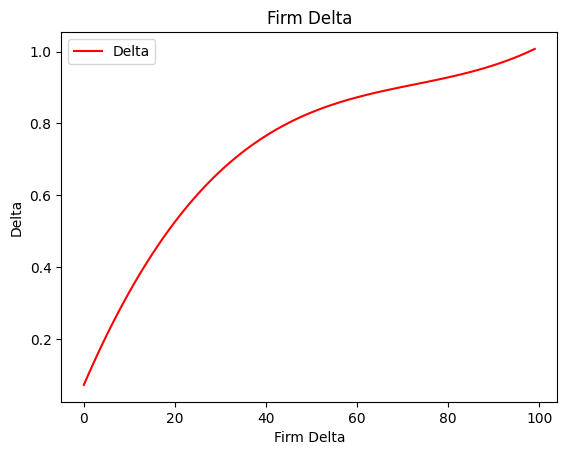

In [145]:
## Firm Delta

x = range(0, 100)
rn_delta_f = np.zeros(len(x))
esos = np.zeros(len(x))

for i in x:
    esos[i] = rn_eso(i,K_init, T_init, v_init, r_init, N_init, sigma_init, m_init)
    a = esos[i] = rn_eso(i,K_init, T_init, v_init, r_init, N_init, sigma_init, m_init)
    b = rn_eso(i+1,K_init, T_init, v_init, r_init, N_init, sigma_init, m_init)
    delta = (b-a)

    rn_delta_f[i] = delta


# Fit a smooth line to the delta values
z = np.polyfit(x, rn_delta_f, 3)  # 3rd degree polynomial
p = np.poly1d(z)

# Generate x values for the smooth line
x_smooth = np.linspace(min(x), max(x), 100)

# Generate y values for the smooth line
y_smooth = p(x_smooth)

# Plot the smooth line
plt.plot(x_smooth, y_smooth, color='red', label='Delta')

# Plot the raw delta values
#plt.plot(x, rn_delta_f, label='Delta (raw)')

plt.xlabel('Firm Delta')
plt.ylabel('Delta')
plt.title('Firm Delta')
plt.legend()
plt.show()





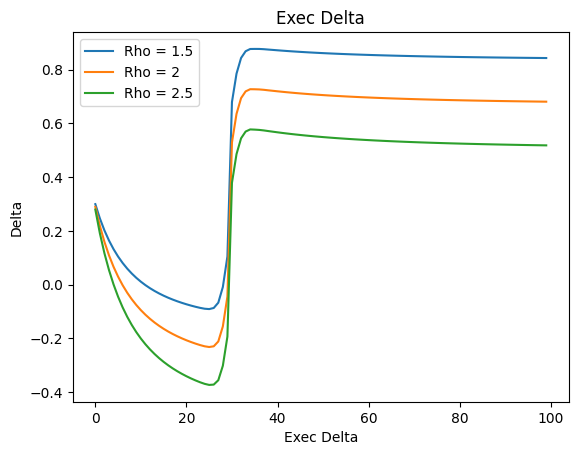

In [144]:
## Exec Delta 

x = range(0, 100)
rn_delta_e_lowest = np.zeros(len(x))
rn_delta_e_low = np.zeros(len(x))
rn_delta_e_med = np.zeros(len(x)) 
rn_delta_e_high = np.zeros(len(x))
esos_lowest = np.zeros(len(x))
esos_low = np.zeros(len(x))
esos_med = np.zeros(len(x))
esos_high = np.zeros(len(x))

'''
rho_init = 1.1
for i in x:
    esos_lowest[i] = CE_rn(i, K_init, T_init, v_init, r_init, N_init_r, sigma_init, rho_init, n_s_init, n_o_init, c_init)

    a = esos_lowest[i]
    b = CE_rn(i+1,K_init, T_init, v_init, r_init, N_init_r, sigma_init, rho_init, n_s_init, n_o_init, c_init)
    delta = (b-a)/1

    rn_delta_e_lowest[i] = delta
'''

rho_init = 1.5
for i in x:
    esos_low[i] = CE_rn(i, K_init, T_init, v_init, r_init, N_init_r, sigma_init, rho_init, n_s_init, n_o_init, c_init)

    a = esos_low[i]
    b = CE_rn(i+1,K_init, T_init, v_init, r_init, N_init_r, sigma_init, rho_init, n_s_init, n_o_init, c_init)
    delta = (b-a)/1

    rn_delta_e_low[i] = delta


rho_init = 2
for i in x:
    esos_med[i] = CE_rn(i, K_init, T_init, v_init, r_init, N_init_r, sigma_init, rho_init, n_s_init, n_o_init, c_init)

    a = esos_med[i]
    b = CE_rn(i+1,K_init, T_init, v_init, r_init, N_init_r, sigma_init, rho_init, n_s_init, n_o_init, c_init)
    delta = (b-a)/1

    rn_delta_e_med[i] = delta


rho_init = 2.5
for i in x:
    esos_high[i] = CE_rn(i, K_init, T_init, v_init, r_init, N_init_r, sigma_init, rho_init, n_s_init, n_o_init, c_init)

    a = esos_high[i]
    b = CE_rn(i+1,K_init, T_init, v_init, r_init, N_init_r, sigma_init, rho_init, n_s_init, n_o_init, c_init)
    delta = (b-a)/1

    rn_delta_e_high[i] = delta



# Plot the delta values
plt.plot(x, rn_delta_e_low, label='Rho = 1.5')
plt.plot(x, rn_delta_e_med, label='Rho = 2')
plt.plot(x, rn_delta_e_high, label='Rho = 2.5')


plt.xlabel('Exec Delta')
plt.ylabel('Delta')
plt.title('Exec Delta')
plt.legend()
plt.show()





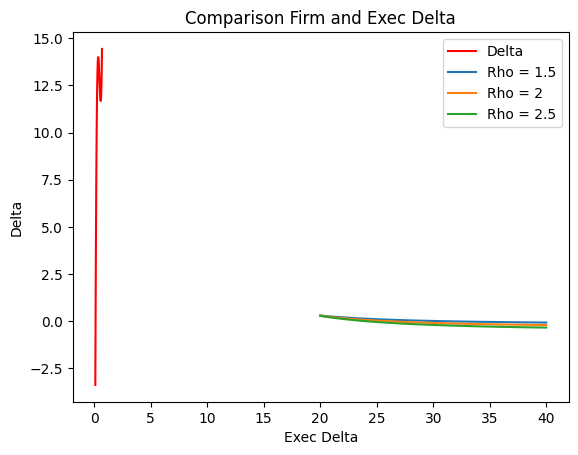

In [143]:
plt.plot(x_smooth, y_smooth, color='red', label='Delta')

plt.plot(x, rn_delta_e_low, label='Rho = 1.5')
plt.plot(x, rn_delta_e_med, label='Rho = 2')
plt.plot(x, rn_delta_e_high, label='Rho = 2.5')


plt.xlabel('Exec Delta')
plt.ylabel('Delta')
plt.title('Comparison Firm and Exec Delta')
plt.legend()
plt.show()

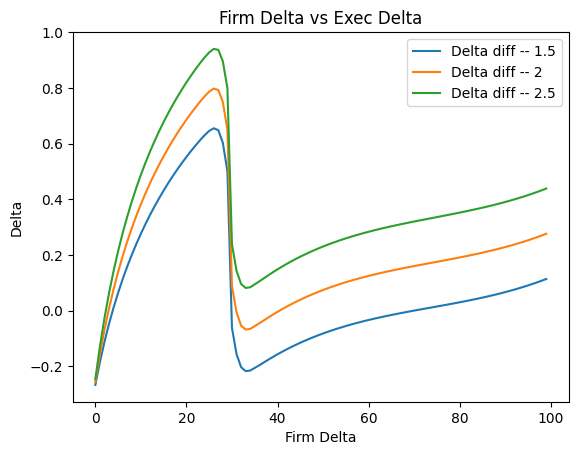

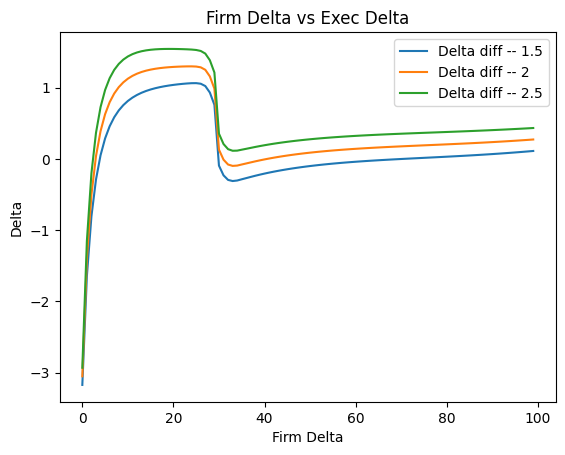

In [79]:
## Difference Ratio
diff_low = np.zeros(len(x))
diff_med = np.zeros(len(x))
diff_high = np.zeros(len(x))


for i in x:
    diff_low[i] = y_smooth[i] - rn_delta_e_low[i]
    diff_med[i] = y_smooth[i] - rn_delta_e_med[i]
    diff_high[i] = y_smooth[i] - rn_delta_e_high[i]

#Plot Difference Ratio
plt.plot(x, diff_low, label='Delta diff -- 1.5')
plt.plot(x, diff_med, label='Delta diff -- 2')
plt.plot(x, diff_high, label='Delta diff -- 2.5')

plt.xlabel('Firm Delta')
plt.ylabel('Delta')
plt.title('Firm Delta vs Exec Delta')
plt.legend()
plt.show()



for i in x:
    diff_low[i] = diff_low[i]/y_smooth[i]
    diff_med[i] = diff_med[i]/y_smooth[i]
    diff_high[i] = diff_high[i]/y_smooth[i]

#Plot Difference Ratio
plt.plot(x, diff_low, label='Delta diff -- 1.5')
plt.plot(x, diff_med, label='Delta diff -- 2')
plt.plot(x, diff_high, label='Delta diff -- 2.5')

plt.xlabel('Firm Delta')
plt.ylabel('Delta')
plt.title('Firm Delta vs Exec Delta')
plt.legend()
plt.show()

## Vega

In [ ]:
## Firm Gamma

x = range(0, 99)
rn_gamma_f = np.zeros(len(x))

for i in x:
    rn_gamma_f[i] = rn_delta_f[i+1]-rn_delta_f[i]


# Fit a smooth line to the gamma values
z = np.polyfit(x, rn_gamma_f, 4)  # 3rd degree polynomial
p = np.poly1d(z)

# Generate x values for the smooth line
x_smooth = np.linspace(min(x), max(x), 99)

# Generate y values for the smooth line
y_smooth = p(x_smooth)

# Plot the smooth line
plt.plot(x_smooth, y_smooth, color='red', label='Vega')

# Plot the delta values
plt.plot(x, rn_vega_f, label='Vega (raw)')

plt.xlabel('Firm Vega')
plt.ylabel('Vega')
plt.title('Firm Vega')
plt.legend()
plt.show()





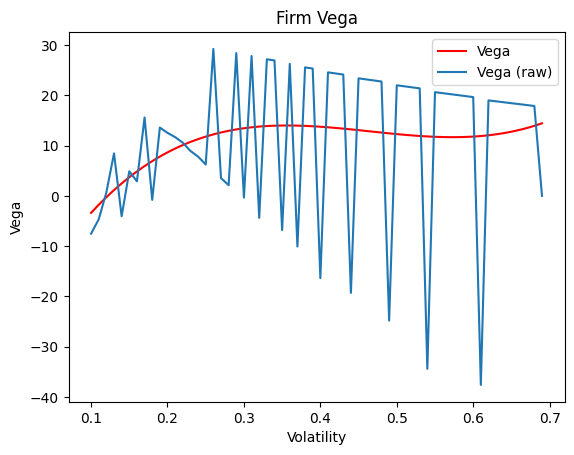

In [98]:
## Firm Vega

x = np.arange(0.2, 0.5, 0.01)
rn_vega_f = np.zeros(len(x))
esos = np.zeros(len(x))

for i in range(len(x)):
    esos[i] = rn_eso(S0_init,K_init, T_init, v_init, r_init, N_init, x[i], m_init)

for i in range(len(x)-1):
    a = esos[i]
    b = esos[i+1]
    vega = (b-a)/(0.01)

    rn_vega_f[i] = vega


# Fit a smooth line to the delta values
z = np.polyfit(x, rn_vega_f, 3)  # 3rd degree polynomial
p = np.poly1d(z)

# Generate x values for the smooth line
x_smooth = np.linspace(min(x), max(x), len(x))

# Generate y values for the smooth line
y_smooth = p(x_smooth)

# Plot the smooth line
plt.plot(x_smooth, y_smooth, color='red', label='Vega')

# Plot the delta values
plt.plot(x, rn_vega_f, label='Vega (raw)')

plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Firm Vega')
plt.legend()
plt.show()





[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]


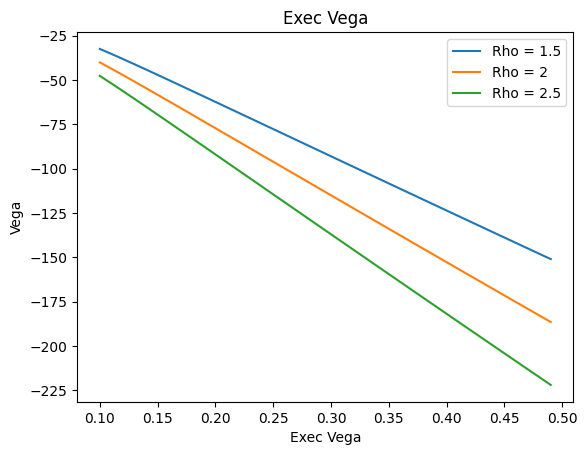

In [109]:
## Exec Vega 

x = np.arange(0.1, 0.51, 0.01)
print(x)
rn_vega_e_lowest = np.zeros(len(x)-1)
rn_vega_e_low = np.zeros(len(x)-1)
rn_vega_e_med = np.zeros(len(x)-1) 
rn_vega_e_high = np.zeros(len(x)-1)
esos_lowest = np.zeros(len(x))
esos_low = np.zeros(len(x))
esos_med = np.zeros(len(x))
esos_high = np.zeros(len(x))

'''
rho_init = 1.1
for i in x:
    esos_lowest[i] = CE_rn(i, K_init, T_init, v_init, r_init, N_init_r, sigma_init, rho_init, n_s_init, n_o_init, c_init)

    a = esos_lowest[i]
    b = CE_rn(i+1,K_init, T_init, v_init, r_init, N_init_r, sigma_init, rho_init, n_s_init, n_o_init, c_init)
    delta = (b-a)/1

    rn_delta_e_lowest[i] = delta
'''

rho_init = 1.5
for i in range(len(x)):
    esos_low[i] = CE_rn(S0_init,K_init, T_init, v_init, r_init, N_init_r, x[i], rho_init, n_s_init, n_o_init, c_init)
    

for i in range(len(x)-1):
    a = esos_low[i]
    b = esos_low[i+1]
    vega = (b-a)/(0.01)

    rn_vega_e_low[i] = vega


rho_init = 2
for i in range(len(x)):
    esos_med[i] = CE_rn(S0_init,K_init, T_init, v_init, r_init, N_init_r, x[i], rho_init, n_s_init, n_o_init, c_init)

for i in range(len(x)-1):
    a = esos_med[i]
    b = esos_med[i+1]
    vega = (b-a)/(0.01)

    rn_vega_e_med[i] = vega


rho_init = 2.5
for i in range(len(x)):
    esos_high[i] = CE_rn(S0_init,K_init, T_init, v_init, r_init, N_init_r, x[i], rho_init, n_s_init, n_o_init, c_init)

for i in range(len(x)-1):
    a = esos_high[i]
    b = esos_high[i+1]
    vega = (b-a)/(0.01)

    rn_vega_e_high[i] = vega

x = np.arange(0.1, 0.5, 0.01)


# Plot the delta values
plt.plot(x, rn_vega_e_low, label='Rho = 1.5')
plt.plot(x, rn_vega_e_med, label='Rho = 2')
plt.plot(x, rn_vega_e_high, label='Rho = 2.5')


plt.xlabel('Exec Vega')
plt.ylabel('Vega')
plt.title('Exec Vega')
plt.legend()
plt.show()





## Deadweight Cost

15.510669860393381 17.318741352322203 14.04665769468372 10.779232580003638
15.101307842737183 16.318158186522002 13.045879836867874 9.778260102504865
14.996281470654232 15.317590584155793 12.045119257780414 8.777306808916231
14.664038903685181 14.31708251884207 11.04442398577618 7.776425142589336
14.364463625594064 13.31679301266248 10.043965472451722 6.775799906551838
14.102917814847745 12.31727509893477 9.044332281695679 5.776057306071744
13.579262991541531 11.320366939048593 8.047455351017415 4.779225170972446
13.349602949296335 10.331826282975575 7.05930494060119 3.791492372720192
13.142040755467088 9.368131394619121 6.0967510077108935 2.8301250470243393
12.965728525941822 8.469012335386749 5.199994223375494 1.9357890610552082
12.788411554664215 7.691058397519712 4.426046105868494 1.1659032366176447
12.634435691045077 7.4907397695072 4.229602848167221 0.9732791666810712
12.214282906443179 7.3945273464825005 4.135761858920256 0.8817554602647821
12.090029298438509 7.356117588443061 4

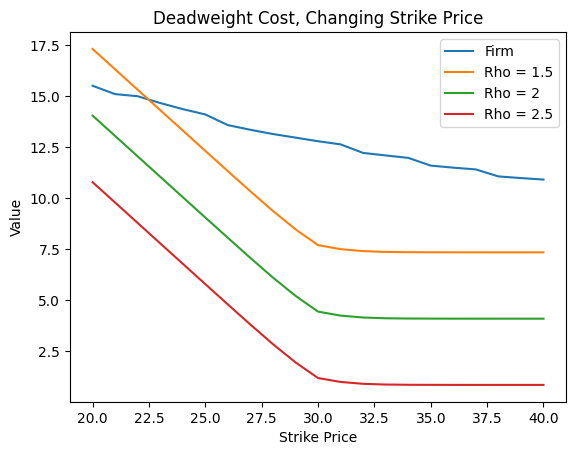

In [122]:
x = np.arange(20,41,1)
f, low, med, high = np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x))

i = 0
for k in x:
    f[i] = rn_eso(S0_init,k, T_init, v_init, r_init, N_init, sigma_init, m_init)

    low[i] = CE_rn(S0_init,k, T_init, v_init, r_init, N_init_r, sigma_init, 1.5, n_s_init, n_o_init, c_init)
    med[i] = CE_rn(S0_init,k, T_init, v_init, r_init, N_init_r, sigma_init, 2, n_s_init, n_o_init, c_init)
    high[i] = CE_rn(S0_init,k, T_init, v_init, r_init, N_init_r, sigma_init, 2.5, n_s_init, n_o_init, c_init)

    print(f[i],low[i],med[i],high[i])
    i = i+1

plt.plot(x, f, label='Firm')
plt.plot(x, low, label='Rho = 1.5')
plt.plot(x, med, label='Rho = 2')
plt.plot(x, high, label='Rho = 2.5')


plt.xlabel('Strike Price')
plt.ylabel('Value')
plt.title('Deadweight Cost, Changing Strike Price')
plt.legend()
plt.show()


11.287085751448851 19.872076513531308 19.498016270591567 19.124655532039082
11.211872138828847 19.54749117743224 19.097401941586284 18.64815166993377
11.1651757391358 19.194819952513402 18.661468463636314 18.129106895144407
11.171977747932754 18.81323017815128 18.18938625941674 17.56669420149798
11.256441389477382 18.402178695254648 17.680615201468267 16.960375934463617
11.21593281597347 17.961300058948495 17.134792919484898 16.30979219326439
11.264780291926662 17.490342153099675 16.55167046932814 15.614696554631616
11.293730314554889 16.989127545220157 15.931073720591764 14.874917493496712
11.44969403283544 16.45752945514396 15.272879345606391 14.090334392730147
11.441771948097491 15.895456344690174 14.576999422227964 13.26086215950859
11.577618959429744 15.30284176570053 13.843371290458988 12.386441091081748
11.702936259432411 14.679637510733057 13.071950709053004 11.467030037790536
11.819756252385126 14.025808892892673 12.262707139352957 10.502601691549645
11.925496848618392 13.3413

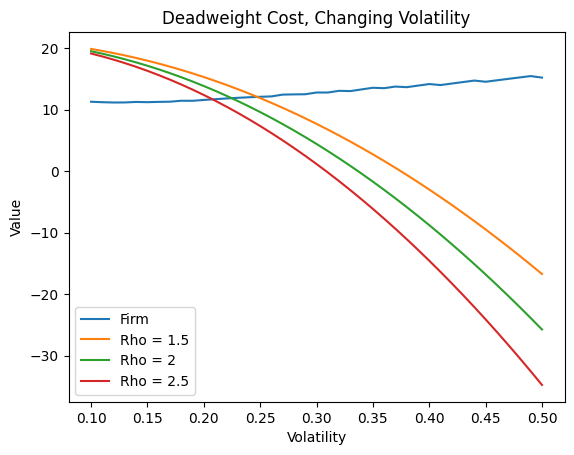

In [121]:
x = np.arange(0.1,0.51,0.01)
f, low, med, high = np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x))

i = 0
for sigma in x:
    f[i] = rn_eso(S0_init,K_init, T_init, v_init, r_init, N_init, sigma, m_init)

    low[i] = CE_rn(S0_init,K_init, T_init, v_init, r_init, N_init_r, sigma, 1.5, n_s_init, n_o_init, c_init)
    med[i] = CE_rn(S0_init,K_init, T_init, v_init, r_init, N_init_r, sigma, 2, n_s_init, n_o_init, c_init)
    high[i] = CE_rn(S0_init,K_init, T_init, v_init, r_init, N_init_r, sigma, 2.5, n_s_init, n_o_init, c_init)

    print(f[i],low[i],med[i],high[i])
    i = i+1

plt.plot(x, f, label='Firm')
plt.plot(x, low, label='Rho = 1.5')
plt.plot(x, med, label='Rho = 2')
plt.plot(x, high, label='Rho = 2.5')


plt.xlabel('Volatility')
plt.ylabel('Value')
plt.title('Deadweight Cost, Changing Volatility')
plt.legend()
plt.show()


In [114]:
x = np.arange(20,41,1)
f, low, med, high = np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x))

i = 0
for s in x:
    f[i] = rn_eso(s,K_init, T_init, v_init, r_init, N_init, sigma_init, m_init)

    low[i] = CE_rn(s,K_init, T_init, v_init, r_init, N_init_r, sigma_init, 1.5, n_s_init, n_o_init, c_init)
    med[i] = CE_rn(s,K_init, T_init, v_init, r_init, N_init_r, sigma_init, 2, n_s_init, n_o_init, c_init)
    high[i] = CE_rn(s,K_init, T_init, v_init, r_init, N_init_r, sigma_init, 2.5, n_s_init, n_o_init, c_init)

    print(f[i],low[i],med[i],high[i])
    i = i+1

plt.plot(x, f, label='Firm')
plt.plot(x, low, label='Rho = 1.5')
plt.plot(x, med, label='Rho = 2')
plt.plot(x, high, label='Rho = 2.5')


plt.xlabel('Initial Stock Price')
plt.ylabel('Value')
plt.title('Deadweight Cost, Changing Initial Stock Price')
plt.legend()
plt.show()


6.609269385539118 7.7261537718912585 5.8701058997570845 4.01752838233641
7.198845074562347 7.7051923798055695 5.71520448361213 3.7288414817039546
7.792572092953795 7.679352649861636 5.553786147828214 3.4319909023540096
8.38628958145373 7.649050075169653 5.386389563741783 3.1276388074085117
8.985920556148788 7.614758344513054 5.213591900179162 2.816466682062795
9.576482315102302 7.577258792075639 5.036246614642441 2.4994020748573047
10.172427268757417 7.538452650653198 4.856264531783139 2.1783694504046194
10.76339478523651 7.503838298308352 4.6790279089007525 1.8586415473061304
11.343977008066716 7.489138747854159 4.519945120525857 1.5553184504713864
12.19928274185685 7.53303008395868 4.417250827721631 1.306191059856986
12.788411554664215 7.691058397519712 4.426046105868494 1.1659032366176447
13.38253966752142 8.42392415445298 5.008608009678622 1.5981913615949452
13.954696290004385 9.262069214119887 5.697054768586531 2.136958457622677
14.841548196339318 10.15828261017489 6.4438137712702

# Values' Ratio

In [138]:
#Executive Value Ratio
alphas = [0.5, 0.75, 1]
r_low = [5.41792982430507, 11.9709054440632, 5.56720972910833]
r_med = [2.14068001705842, 8.67098567015491, 2.30288947724426]
r_high = [-1.1279023259102, 5.37756769774171, -0.957186751396705]

ratio_low = [r_low[i]/r_low[2] * 100 for i in range(3)]
ratio_med = [r_med[i]/r_med[2] * 100 for i in range(3)]
ratio_high = [abs(r_high[i])/abs(r_high[2]) * 100 for i in range(3)]

print(ratio_low)
print(ratio_med)
print(ratio_high)

[97.3185866517163, 215.02522855341604, 100.0]
[92.95626378127591, 376.5263489992145, 100.0]
[117.83513763269191, 561.8096667024367, 100.0]


[15.20492823 14.72162489 13.99666989 13.75501822 13.27171489 12.78841155]


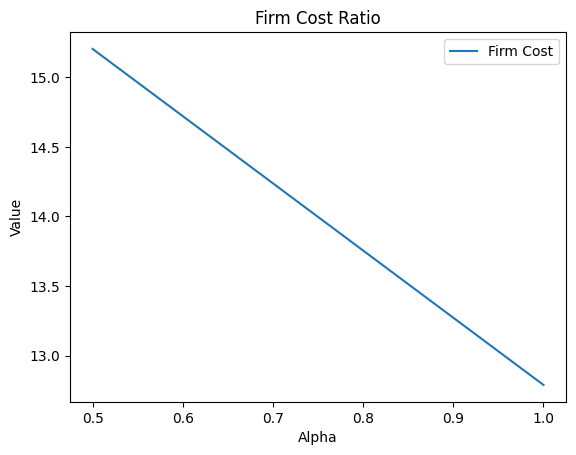

In [133]:
#Firm Cost Ratio
alphas = [0.5, 0.6, 0.75, 0.8, 0.9, 1]
firm_cost = np.zeros(len(alphas))

for i in np.arange(len(alphas)):
    firm_cost[i] = r_eso_mod(S0_init,K_init,T_init,v_init,r_init,N_init,sigma_init,m_init,alphas[i],0)

print(firm_cost)

plt.plot(alphas, firm_cost, label='Firm Cost')
plt.xlabel('Alpha')
plt.ylabel('Value')
plt.title('Firm Cost Ratio')
plt.legend()
plt.show()



##==> Costier for the firm giving the reload option